In [47]:
import numpy as np
import pytesseract
import argparse
import imutils
import cv2
from matplotlib import pyplot as plt

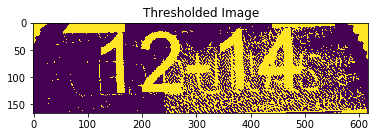

In [48]:
image = cv2.imread("./in/tesseract_failing.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# threshold the image using Otsu's thresholding method
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cv2.imwrite("./out/tesseract_thresh.png", thresh)
plt.imshow(thresh)
plt.title("Thresholded Image")
plt.show()

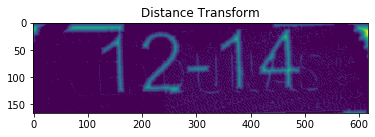

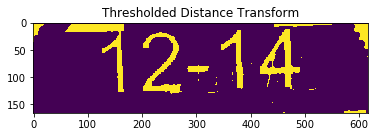

In [49]:
# apply a distance transform which calculates the distance to the
# closest zero pixel for each pixel in the input image
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

# normalize the distance transform such that the distances lie in
# the range [0, 1] and then convert the distance transform back to
# an unsigned 8-bit integer in the range [0, 255]
dist = cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
dist = (dist * 255).astype("uint8")
cv2.imwrite("./out/tesseract_dist.png", dist)
plt.imshow(dist)
plt.title("Distance Transform")
plt.show()

# threshold the distance transform using Otsu's method
dist = cv2.threshold(dist, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
cv2.imwrite("./out/tesseract_dist_thresh.png", dist)
plt.imshow(dist)
plt.title("Thresholded Distance Transform")
plt.show()

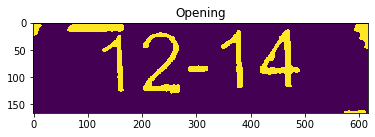

In [50]:
# apply an "opening" morphological operation to disconnect components
# in the image
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
opening = cv2.morphologyEx(dist, cv2.MORPH_OPEN, kernel)
cv2.imwrite("./out/tesseract_opening.png", opening)
plt.imshow(opening)
plt.title("Opening")
plt.show()

In [51]:
# find contours in the opening image, then initialize the list of
# contours which belong to actual characters that we will be OCR'ing
cnts = cv2.findContours(opening.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
chars = []
# loop over the contours
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# check if contour is at least 35px wide and 100px tall, and if
	# so, consider the contour a digit
	if w >= 20 and h >= 70:
		chars.append(c)

print("found", len(chars))

found 4


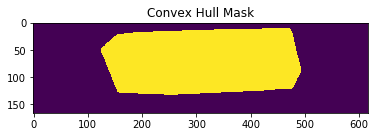

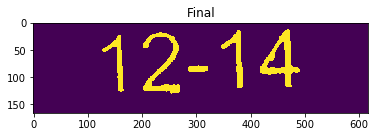

In [52]:
# compute the convex hull of the characters
chars = np.vstack([chars[i] for i in range(0, len(chars))])
hull = cv2.convexHull(chars)

# allocate memory for the convex hull mask, draw the convex hull on
# the image, and then enlarge it via a dilation
mask = np.zeros(image.shape[:2], dtype="uint8")
cv2.drawContours(mask, [hull], -1, 255, -1)
mask = cv2.dilate(mask, None, iterations=2)
cv2.imwrite("./out/tesseract_mask.png", mask)
plt.imshow(mask)
plt.title("Convex Hull Mask")
plt.show()

# take the bitwise of the opening image and the mask to reveal *just*
# the characters in the image
final = cv2.bitwise_and(opening, opening, mask=mask)
cv2.imwrite("./out/tesseract_final.png", final)
plt.imshow(final)
plt.title("Final")
plt.show()

In [53]:
# OCR the input image using Tesseract
options = "--psm 8 -c tessedit_char_whitelist=0123456789"
text = pytesseract.image_to_string(final, config=options)
print(text)

1214

